# XGBoost

This notebook was created before the .py runner, and is only kept to understand each step of this approach, but to run the different tests and read the code please use the runners.
The runner is up to date, this version is not. Additionally, results obtained in the report were obtained with the runners and not the notebooks

## Read data

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from electricity_price_forecast.eval import get_test_metrics
from electricity_price_forecast.data.data_visualization import plot_prices, plot_predictions_vs_real
from electricity_price_forecast.data.data_processing import preprocess_true_data, preprocess_synthetic_data


from typing import List

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

In [2]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [4]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,58.82,2016-12-31 23:00:00+00:00,5,23,366,0,31,12,2016,0
1,58.23,2017-01-01 00:00:00+00:00,6,0,1,1,1,1,2017,1
2,51.95,2017-01-01 01:00:00+00:00,6,1,1,1,1,1,2017,2
3,47.27,2017-01-01 02:00:00+00:00,6,2,1,1,1,1,2017,3
4,45.49,2017-01-01 03:00:00+00:00,6,3,1,1,1,1,2017,4


In [5]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,31.66,2016-12-31 00:00:00+00:00,5,0,366,0,31,12,2016,0
1,31.06,2016-12-31 01:00:00+00:00,5,1,366,0,31,12,2016,1
2,27.81,2016-12-31 02:00:00+00:00,5,2,366,0,31,12,2016,2
3,27.54,2016-12-31 03:00:00+00:00,5,3,366,0,31,12,2016,3
4,25.04,2016-12-31 04:00:00+00:00,5,4,366,0,31,12,2016,4


## Plot data

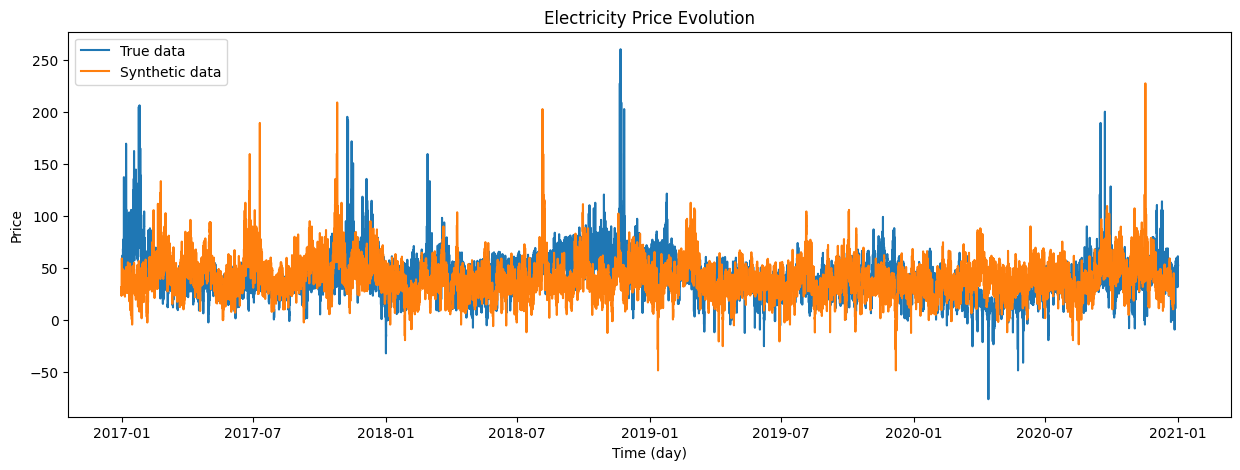

In [6]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Feature Engineering

One example x is `[dayofweek, hourofday, dayofseries]` or another set of attributes and y is `price`

In [7]:
def get_x_y_point_by_point(df, x_keys: List[str], y_key: str):
    X = df[x_keys]
    y = df[y_key]
    return X, y

One example x is a sequence of values of one attribute (e.g. x is `dayofseries_1, dayofseries_2, ..., dayofseries_5`) using a window and y is `price`

In [8]:
def get_x_y_window(df, y_key: str, window_size: int, window_step: int, horizon: int):
    X, y  = [], []
    for i in range(0, len(df[y_key]) - window_size - horizon, window_step):
        X.append(df[y_key][i:i+window_size])
        y.append(df[y_key][i+window_size:i+window_size+horizon])
        
    return X, y

## Train & Test Splits

In [9]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

## Training functions

In [10]:
def get_best_params(X_train, y_train):
    xgb_model = xgb.XGBRegressor()
    reg_cv = GridSearchCV(xgb_model, {'max_depth': [1,5,10], 'n_estimators': [50, 200, 500], 'learning_rate': [0.001, 0.01, 0.1]}, verbose=1)
    reg_cv.fit(X_train, y_train)
    return reg_cv.best_params_

def train_model(X_train, y_train, params=None):
    if params is None:
        xgb_model = xgb.XGBRegressor()
    else:
        xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train,y_train)
    
    return xgb_model

## Point by point

### Without data augmentation

#### Search hyper params

In [11]:
n_before = 24
horizon = 24

In [12]:
train_data, test_data = split_data(df_price_preprocessed, horizon+n_before)
X_train, y_train = get_x_y_point_by_point(train_data, ["dayofweek", "hourofday", "dayofseries"], "price")
X_test, y_test = get_x_y_point_by_point(test_data, ["dayofweek", "hourofday", "dayofseries"], "price")

# params = get_best_params(X_train, y_train)
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}

#### Train and eval

In [13]:
xgb_model = train_model(X_train, y_train, params)

Results: {'MAE': 12.89567767937978, 'MSE': 174.93994501056827, 'RMSE': 13.226486495308126}


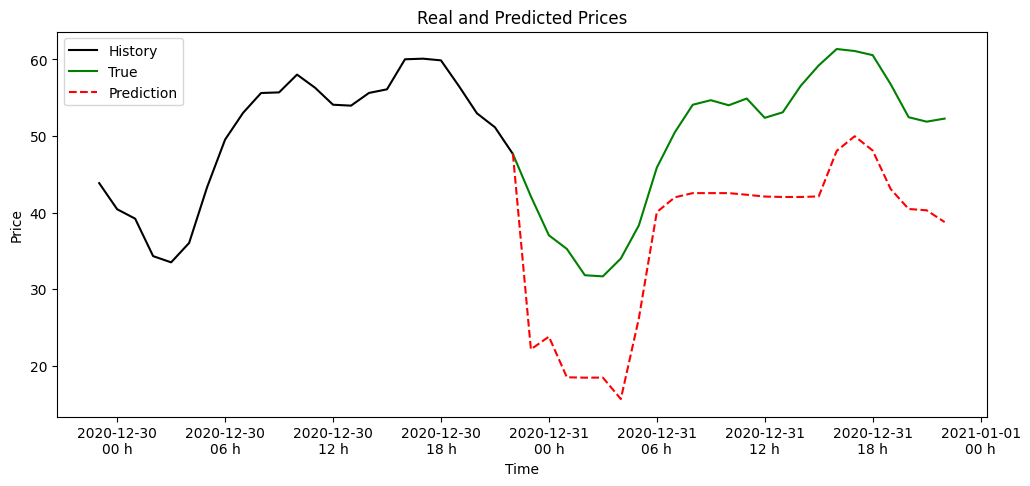

In [14]:
predictions = xgb_model.predict(X_test[-n_before:])

results = get_test_metrics(predictions, y_test[-n_before:])

print("Results:", results)
plot_predictions_vs_real(df_price_preprocessed["date"][X_test.index].values, y_test.values, predictions)

### With provided data augmentation (synthetic data)

In [15]:
def load_synthetic_data_point_by_point(path, max_files=None):
    X_train_all, y_train_all = [], []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_files is not None and i >= max_files:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            X_train, y_train = get_x_y_point_by_point(df_preprocessed, ["dayofweek", "hourofday", "dayofseries"], "price")
            
            X_train_all.append(X_train)
            y_train_all.append(y_train)
    
    X_train_all = pd.concat(X_train_all)
    y_train_all = pd.concat(y_train_all)

    return X_train_all, y_train_all

In [16]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_point_by_point(directory, 20)
X_train_all = pd.concat([X_train, X_train_synthetic])
y_train_all = pd.concat([y_train, y_train_synthetic])

 13%|█▎        | 20/154 [00:00<00:01, 75.75it/s]


In [17]:
xgb_model = train_model(X_train_synthetic, y_train_synthetic, params)

Results: {'MAE': 8.036881710688272, 'MSE': 88.85392093667956, 'RMSE': 9.42623577769406}


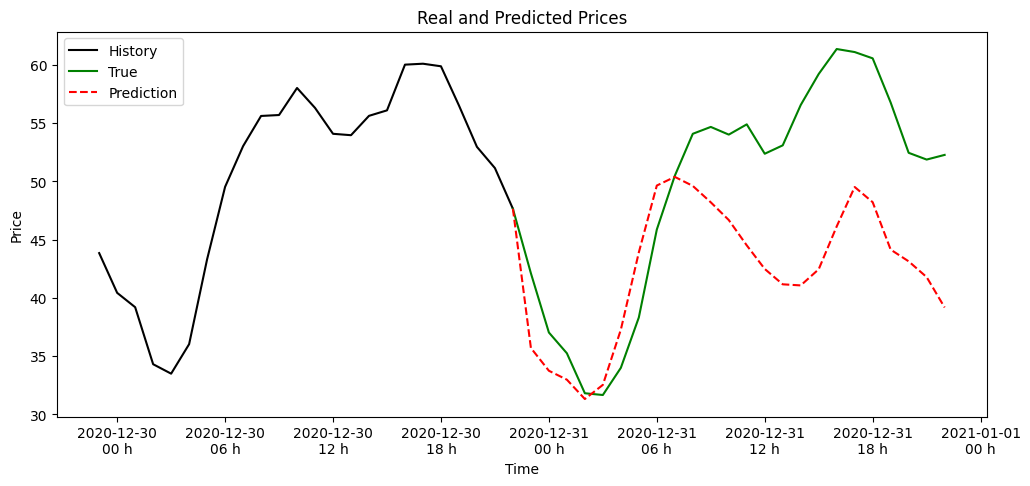

In [18]:
predictions = xgb_model.predict(X_test[-n_before:])
results = get_test_metrics(predictions[-n_before:], y_test[-n_before:])
print("Results:", results)
plot_predictions_vs_real(df_price_preprocessed["date"][X_test.index].values, y_test.values, predictions)

## Window

### Without data augmentation



In [19]:
window_size = 24
window_step = 12
test_size = window_size + horizon + 1

In [20]:
params = {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}

In [21]:
train_data, test_data = split_data(df_price_preprocessed, test_size)
X_train, y_train = get_x_y_window(train_data, "price", window_size, window_step, horizon)
X_test, y_test = get_x_y_window(test_data, "price", window_size, window_step, horizon)
# params = get_best_params(X_train, y_train)

#### Train and eval

In [22]:
xgb_model = train_model(X_train, y_train, params)

In [23]:
start, end = X_test[0].index[0], y_test[0].index[-1]
X_test_hourofseries = list(range(start, end+1))
X_test_dates = [df_price_preprocessed["date"].iloc[i] for i in X_test_hourofseries]
y_test_true = [df_price_preprocessed["price"].iloc[i] for i in X_test_hourofseries]

Results: {'MAE': 5.236706943511963, 'MSE': 42.91454203526532, 'RMSE': 6.550919174838392}


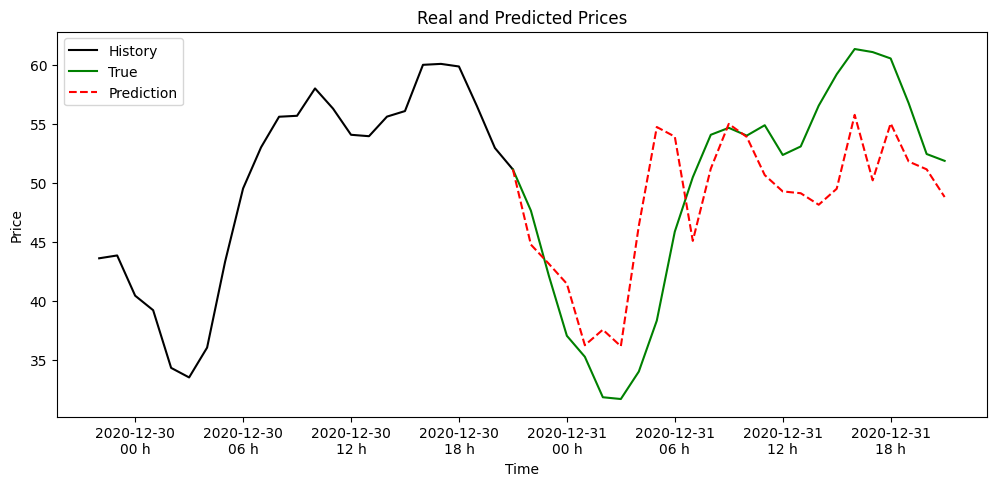

In [24]:
predictions = xgb_model.predict(X_test)
results = get_test_metrics(predictions, y_test)
print("Results:", results)
plot_predictions_vs_real(X_test_dates, y_test_true, predictions[0])

### With provided data augmentation (synthetic data)

In [25]:
def load_synthetic_data_window(path, max_files=None):
    X_train_all, y_train_all = [], []
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_files is not None and i >= max_files:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            
            X_train, y_train = get_x_y_window(df_preprocessed, "price", window_size, window_step, horizon)
            
            X_train_all.extend(X_train)
            y_train_all.extend(y_train)

    return X_train_all, y_train_all

In [26]:
directory = "../data/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_window(directory, 20)
X_train_all = X_train + X_train_synthetic
y_train_all = y_train + y_train_synthetic

 13%|█▎        | 20/154 [00:03<00:20,  6.55it/s]


In [27]:
xgb_model = train_model(X_train_all, y_train_all, params)

In [28]:
start, end = X_test[0].index[0], y_test[0].index[-1]
X_test_hourofseries = list(range(start, end+1))
X_test_dates = [df_price_preprocessed["date"].iloc[i] for i in X_test_hourofseries]
y_test_true = [df_price_preprocessed["price"].iloc[i] for i in X_test_hourofseries]

Results: {'MAE': 5.236706943511963, 'MSE': 42.91454203526532, 'RMSE': 6.550919174838392}


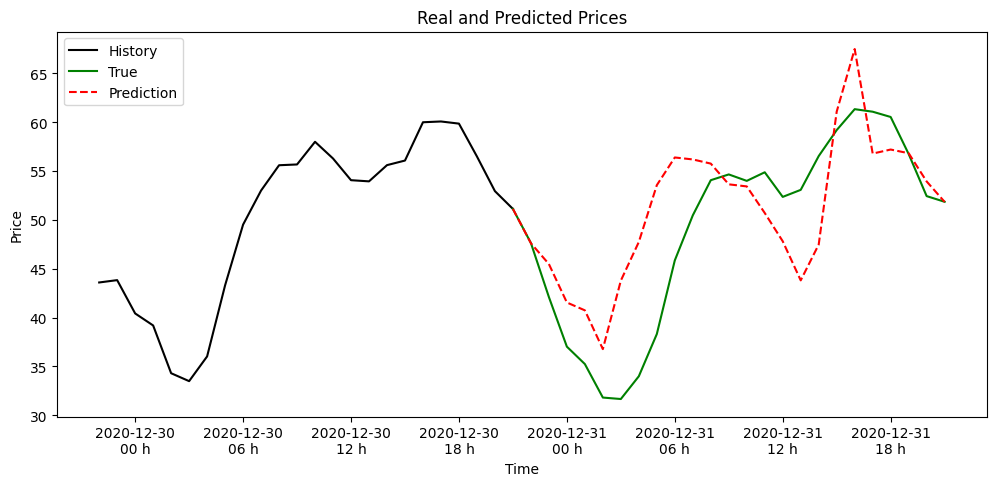

In [29]:
predictions = xgb_model.predict(X_test[-n_before:])
print("Results:", results)
plot_predictions_vs_real(X_test_dates, y_test_true, predictions[0])